In [1]:
import spynnaker8 as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt

import time
import numpy as np
import math
import cv2
import pdb


import sys
sys.path.insert(1, '../../miscelaneous')
from spinnorse_tools import fetch_files, plot_in_v_out, plot_spikes, plot_voltages
from stimulator import produce_data

In [2]:
duration = 3
l_px = 24
w_px = int(l_px*3/4)
vx =  l_px/80
vy = -w_px/160
r_ball = int(3+w_px/48)
mat, coor = produce_data(l_px, w_px, r_ball, vx, vy, duration)
# print(mat[3,4,:])

In [3]:
dt = 1           # (ms) simulation timestep

cell_params = {'tau_m': 20.0,
               'tau_syn_E': 5.0,
               'tau_syn_I': 5.0,
               'v_rest': -65.0,
               'v_reset': -65.0,
               'v_thresh': -50.0,
               'tau_refrac': 0.0, # 0.1 originally
               'cm': 1,
               'i_offset': 0.0
               }

w = 1.0
w_fovea = 0.5

In [4]:
nb_steps = duration*1000


#SpiNNaker Setup
delay = dt
node_id = p.setup(timestep=dt, min_delay=delay, max_delay=delay)     
p.set_number_of_neurons_per_core(p.IF_curr_exp, 100) #  100 neurons per core


celltype = p.IF_curr_exp

cells_l0 = []  
cells_l1 = []   
con_l0l1 = []  
con_move = []
w_x = np.zeros((2,l_px))
w_y = np.zeros((2,w_px))

idx = -1

m_labels = ["go_right", "go_left", "go_up", "go_down"]
colors = ["g", "r", "g", "r"]

move_neurons = []
for i in range(len(m_labels)):
    move_neurons.append(p.Population(1, celltype(**cell_params), label=m_labels[i]) )
    move_neurons[i].record(["v","spikes"])


for y in range(w_px):
        
    for x in range(l_px):
        
        idx += 1
        i_spikes = mat[y, x, :]
        i_indexes = np.where(i_spikes > 0)
        spike_trains = p.SpikeSourceArray(spike_times=(i_indexes))

        cur_label = "N_{:d}_{:d}".format(x, y)
        
        # Populations        
        cells_l0.append(p.Population(1,spike_trains))        
#         cells_l1.append(p.Population(1, celltype(**cell_params), label=cur_label))


        # Connectivity
        cell_conn = p.AllToAllConnector()
        cur_label = "i2l_{:d}_{:d}".format(x, y)         
#         con_l0l1.append({ 'i1l1': p.Projection(cells_l0[idx], cells_l1[idx], cell_conn,
#                                 receptor_type='excitatory',
#                                 synapse_type=p.StaticSynapse(weight=w, delay=delay))})
        
        # Move right (when stimulus on the left 'hemisphere')    
        if x < l_px/2:
            w_motor_x = w_fovea*(abs(x-l_px/2)/l_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[0], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_x, delay=delay))})
    
        # Move Left (when stimulus on the right 'hemisphere')
        if x > l_px/2:
            w_motor_x = w_fovea*(abs(x-l_px/2)/l_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[1], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_x, delay=delay))})
        
        # Move up (when stimulus on the bottom 'hemisphere')     
        if y < w_px/2: # higher pixel --> bottom of image
            w_motor_y = w_fovea*(abs(y-w_px/2)/w_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[2], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_y, delay=delay))})
        
        # Move down (when stimulus on the top 'hemisphere') 
        if y > w_px/2: # lower pixel --> top of image
            w_motor_y = w_fovea*(abs(y-w_px/2)/w_px )
            con_move.append({ 'l1lm': p.Projection(cells_l0[idx], move_neurons[3], cell_conn,
                                            receptor_type='excitatory',
                                            synapse_type=p.StaticSynapse(weight=w_motor_y, delay=delay))})
        
        
#         print("N_{:d}_{:d} --> ({:.3f},{:.3f})".format(x, y, w_motor_x, w_motor_y))
        
        # Setup recording 
        cells_l0[idx].record(["spikes"])
#         cells_l1[idx].record(["v","spikes"])

# print("\n\n\n\n\n\n\n\n")        
        
# Run simulation 
p.run(nb_steps)



        


2022-03-18 16:08:51 INFO: Read cfg files: /home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/juan/.spynnaker.cfg
2022-03-18 16:08:51 INFO: Will search these locations for binaries: /home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2022-03-18 16:08:51 INFO: Setting time scale factor to 1.
2022-03-18 16:08:51 INFO: Setting machine time step to 1000 micro-seconds.


['/home/juan/spinstuff/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/juan/spinstuff/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/juan/.spynnaker.cfg']


2022-03-18 16:08:51 INFO: Starting execution process
2022-03-18 16:08:51 INFO: Simulating for 3000 1.0ms timesteps using a hardware timestep of 1000us
2022-03-18 16:08:51 INFO: Creating transceiver for 172.16.223.29
2022-03-18 16:08:51 INFO: Working out if machine is booted
2022-03-18 16:08:51 INFO: Found board with version [Version: SC&MP 3.4.1 at SpiNNaker:0:0:0 (built Thu Feb 11 15:36:44 2021)]
2022-03-18 16:08:51 INFO: Machine communication successful
2022-03-18 16:08:51 INFO: Detected a machine on IP address 172.16.223.29 which has 856 cores and 120.0 links
2022-03-18 16:08:51 INFO: Time 0:00:00.017767 taken by MachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-03-18 16:08:51 INFO: Time 0:00:00.033018 taken by PreAllocateResourcesForExtraMonitorSupport
2022-03-18 16:08:51 INFO: Time 0:00:00.003958 taken by NetworkSpecificationReport
Allocating virtual identifiers
|0%                       

2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_at

=2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
==2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(l

2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_

2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
=2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_atom=0, hi_atom=0, n_atoms=1) results in a core with a ReverseIPTagMulticastSourceMachineVertex which does not spike
2022-03-18 16:08:52 WARNING: Combination of send_buffer_times [array([], dtype=int64)] and slice Slice(lo_a

|0%                          50%                         100%|
 ==============================2022-03-18 16:08:53 INFO: Time 0:00:00.081419 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2022-03-18 16:08:53 INFO: Time 0:00:00.012749 taken by SystemMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2022-03-18 16:08:53 INFO: Time 0:00:00.008376 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2022-03-18 16:08:53 INFO: Time 0:00:00.121298 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%                         100%|

2022-03-18 16:08:53 INFO: Time 0:00:00.172253 taken by NerRouteTrafficAware
Discovering tag

Reading Routing Tables from Machine
|0%                          50%                         100%|
2022-03-18 16:09:17 INFO: Time 0:00:00.058100 taken by RoutingTableFromMachineReport
Writing fixed route report
|0%                          50%                         100%|
2022-03-18 16:09:17 INFO: Time 0:00:00.044223 taken by FixedRouteFromMachineReport
Loading executables onto the machine
|0%                          50%                         100%|
2022-03-18 16:09:24 INFO: Time 0:00:06.809915 taken by LoadApplicationExecutableImages
2022-03-18 16:09:24 INFO: Running for 1 steps for a total of 3000.0ms
2022-03-18 16:09:24 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2022-03-18 16:09:25 INFO: Time 0:00:00.483362 taken by SdramUsageReportPerChip
2022-03-18 16:09:25 INFO: Time 0:00:00.046577 taken by DatabaseInterface
2022-03-18 16:09:25 INFO: ** Notifying external sources that the database is ready for reading **
2022-0

3000.0

In [5]:

i_indexes = []
o_indexes = []
v_arrays = []
for neuron_nb in range(0,w_px*l_px,1):
    
    in_spikes = cells_l0[neuron_nb].get_data("spikes")
    i_indexes.append(np.asarray(in_spikes.segments[0].spiketrains[0]))   



m_indexes = []
m_v_arrays = []
for i in range(len(m_labels)):    
    spikes = move_neurons[i].get_data("spikes")
    voltage = move_neurons[i].get_data("v")
    m_indexes.append(np.asarray(spikes.segments[0].spiketrains[0]))
    m_v_arrays.append(np.array(voltage.segments[0].filter(name="v")[0]).reshape(-1))


Getting spikes for SpikeSourceArrayVertex_1
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_2
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_3
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_4
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_5
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_6
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_7
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_8
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_9
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVe

Getting spikes for SpikeSourceArrayVertex_50
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_51
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_52
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_53
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_54
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_55
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_56
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_57
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_58
|0%                          50%                         100%|
Getting spikes for SpikeSour

Getting spikes for SpikeSourceArrayVertex_98
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_99
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_100
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_101
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_102
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_103
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_104
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_105
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_106
|0%                          50%                         100%|
Getting spikes for Sp

Getting spikes for SpikeSourceArrayVertex_146
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_147
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_148
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_149
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_150
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_151
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_152
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_153
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_154
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_194
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_195
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_196
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_197
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_198
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_199
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_200
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_201
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_202
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_242
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_243
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_244
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_245
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_246
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_247
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_248
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_249
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_250
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_290
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_291
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_292
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_293
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_294
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_295
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_296
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_297
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_298
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_338
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_339
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_340
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_341
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_342
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_343
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_344
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_345
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_346
|0%                          50%                         100%|
Getting spikes for 

Getting spikes for SpikeSourceArrayVertex_386
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_387
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_388
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_389
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_390
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_391
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_392
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_393
|0%                          50%                         100%|
Getting spikes for SpikeSourceArrayVertex_394
|0%                          50%                         100%|
Getting spikes for 

Getting v for go_right
|0%                          50%                         100%|
Getting spikes for go_left
|0%                          50%                         100%|
Getting v for go_left
|0%                          50%                         100%|
Getting spikes for go_up
|0%                          50%                         100%|
Getting v for go_up
|0%                          50%                         100%|
Getting spikes for go_down
|0%                          50%                         100%|
Getting v for go_down
|0%                          50%                         100%|


In [6]:

p.end()

2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_218:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_218:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_217:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_217:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_240:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_240:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No

2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_18:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_18:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_19:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_19:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_20:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_20:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP p

2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_50:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_50:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_51:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_51:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_52:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_52:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP p

2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_121:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_121:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_122:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_122:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_144:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_144:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No

2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_314:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_336:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_336:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_337:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_337:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_338:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No

2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_388:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_388:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_389:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_389:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_390:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_390:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No

2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_417:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_418:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_418:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_419:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No multicast packets were sent by SpikeSourceArrayVertex_419:0:0.  If you expected packets to be sent this could indicate an error
2022-03-18 16:09:39 WARNING: No SDP packets were received by SpikeSourceArrayVertex_420:0:0.  If you expected packets to be injected, this could indicate an error
2022-03-18 16:09:39 WARNING: No

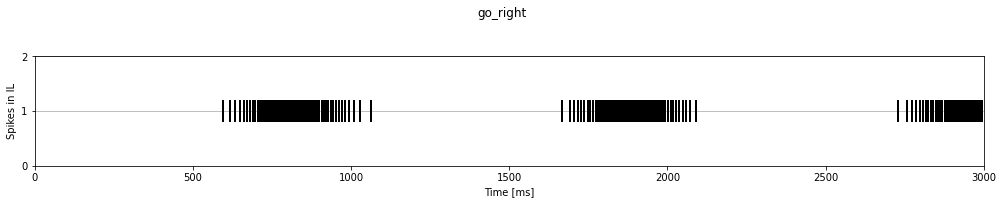

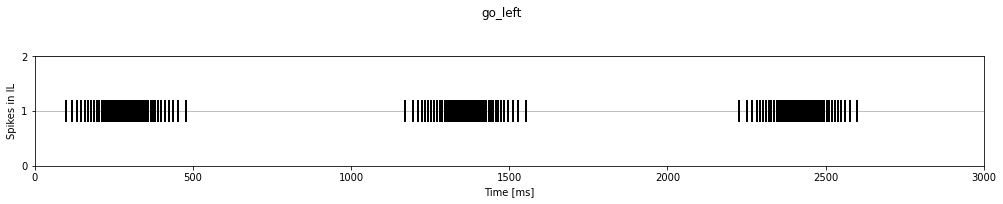

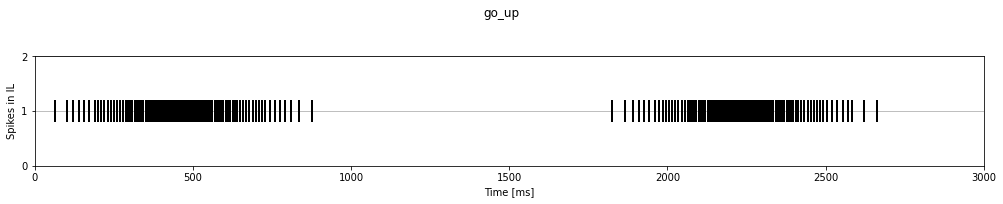

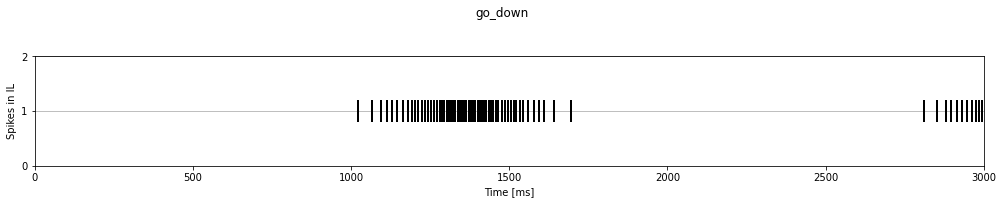

In [7]:

xlim = nb_steps       
for i in range(4):
    plot_spikes(m_indexes[i:i+1], m_labels[i], xlim)
# for i in range(4):
#     plot_voltages(m_v_arrays[i:i+1], m_labels[i], xlim)

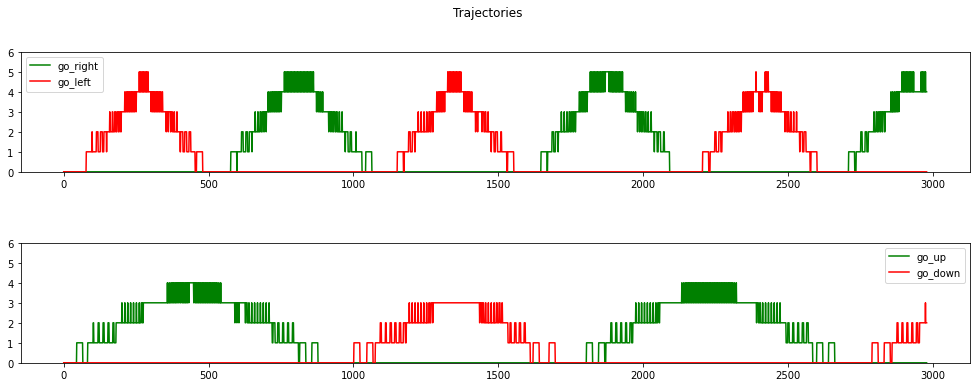

In [8]:

win_size = 20

fig, axs = plt.subplots(2, figsize=(15,6))
fig.tight_layout(pad=5.0)
fig.suptitle("Trajectories")  


# print("{:.1f} %".format(np.round(t/(duration*1000),3)*100))
max_y = 0
for j in range(4):
    neuron_nb = j
    count = np.zeros(nb_steps-win_size)
    for i in range(win_size, nb_steps, 1):
        
        a = np.squeeze(np.array(np.where((m_indexes[neuron_nb]>=(i-win_size)) & (m_indexes[neuron_nb]<=(i)))), axis=0)
        count[i-win_size] = len(a)
        if count[i-win_size] > max_y:
            max_y = count[i-win_size]

    subplot_idx = int(j/2)
    axs[subplot_idx].plot(count, label=m_labels[j], color=colors[j])
    axs[subplot_idx].legend()

    
axs[0].set_ylim([0, int(max_y*1.2)])
axs[1].set_ylim([0, int(max_y*1.2)])
plt.legend()
# plt.xlim([0, 20])

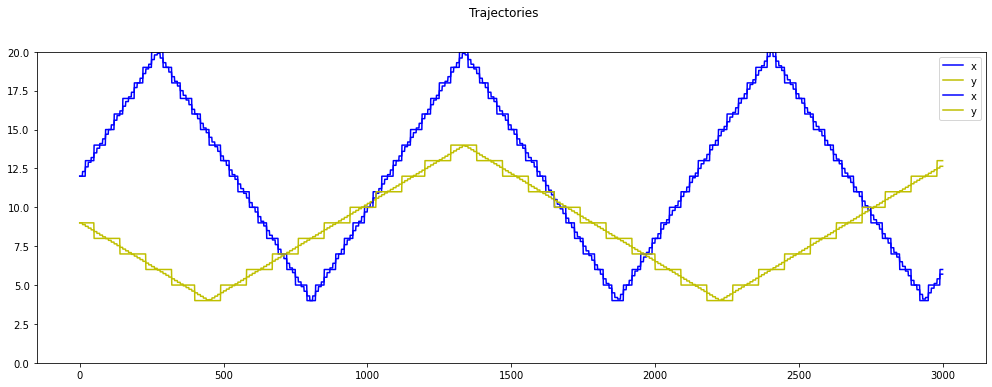

In [9]:
fig, axs = plt.subplots(1, figsize=(15,6))
fig.tight_layout(pad=5.0)
fig.suptitle("Trajectories")  
axs.plot(coor[0,:], label="x", color="b")
axs.plot(coor[1,:], label="y", color="y")
axs.plot(np.round(coor[0,:],0), label="x", color="b")
axs.plot(np.round(coor[1,:],0), label="y", color="y")
axs.set_ylim([0, 20])
plt.legend() 
    